# Moment Estimation of transcriptional parameters

From Bagnall et al. 2020



$$
\begin{align}
   b_m &= \frac{\sigma^2}{\mu} \\\
   \\\
   f_m &= \frac{\mu}{b_m-1} \\\
   \\\
   f_m &= \frac{\mu}{\sigma^2-\mu} \\\
   \\\
\end{align}    
$$


Things to do:

- 

In [221]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end
include(ENV["Code"]*"/../Code_Paper/Code/meanmRNAcounts_BSBF.jl")
using Random, Statistics
using RCall

function bootstrap_mean_std(genedata, gene; cellssubsampled = 50, times = 1000, limit = 2)
    col = :Sample_Rep
    new_df = DataFrames.DataFrame()
    genedata[!,:Sample] = genedata[!,:Genotype] .* "_" .* string.(genedata[!,:Timepoint])
    genedata[!,:Sample_Rep] = genedata[!,:Sample] .* "_" .* string.(genedata[!,:Rep])
    samples = unique(genedata[!,col])
    new_df[!,:Sample_Rep] = samples
    new_df[!,:Genotype] = [split(ii, "_")[1] for ii in samples]
    new_df[!,:Timepoint] = [split(ii, "_")[2] for ii in samples]
    new_df[!,:Rep] = [split(ii, "_")[3] for ii in samples]
    new_df[!,:Sample] = new_df[!,:Genotype] .* "_" .* new_df[!,:Timepoint]
    
    spt = split_by(genedata, col)
    means = []
    stds = []
    means_ = []
    stds_ = []
    bs = []
    bf = []
    
    
    
    for ii in samples
        distribution = spt[ii][!,:N_exon] .+ spt[ii][!,:TSS1_r2]  .+ spt[ii][!,:TSS2_r2] 
        n = length(distribution)
        subdist  = [distribution[shuffle(1:n)[1:cellssubsampled]] for jj in 1:times]
        push!(means, Statistics.mean([Statistics.mean(jj) for jj in subdist]))
        push!(stds, Statistics.mean([Statistics.std(jj) for jj in subdist]))
        push!(means_, Statistics.mean(distribution))
        push!(stds_, Statistics.std(distribution))
        distribution = append!(spt[ii][!,:TSS1_r2], spt[ii][!,:TSS2_r2])
        
        push!(bs, Statistics.mean(distribution[distribution.>limit]))
        push!(bf, Statistics.mean(distribution.>limit))
        
        
        
    end
    new_df[!,:Gene] = [gene for ii in means_]
    new_df[!,:mean] = means_
    new_df[!,:bootstrap_mean] = means
    new_df[!,:std] = stds_
    new_df[!,:bootstrap_std] = stds
    new_df[!,"TSS BS"] =  bs
    new_df[!,"momment BS"] =  (new_df[!,"bootstrap_std"].^2)./ new_df[!,"bootstrap_mean"]
    new_df[!,"TSS BF"] =  bf
    new_df[!,"momment BF"] = new_df[!,"bootstrap_mean"] ./ ( new_df[!,"bootstrap_std"].-1)
    
    new_df
    
end



ifnb1 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Ifnb1_mature.csv", DataFrames.DataFrame)
bf_ifnb1 = bootstrap_mean_std(ifnb1, "Ifnb1")
#bf_ifnb1 = bf_ifnb1[parse.(Int, bf_ifnb1[!,:Timepoint]).==90, :]


il12b = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Il12b_mature_nascent.csv", DataFrames.DataFrame)
bf_il12b = bootstrap_mean_std(il12b, "Il12b")
#bf_il12b = bf_il12b[parse.(Int, bf_il12b[!,:Timepoint]).==90, :]
                
Cxcl10 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Cxcl10_mature.csv", DataFrames.DataFrame)
bf_Cxcl10 = bootstrap_mean_std(Cxcl10, "Cxcl10")
#bf_Cxcl10 = bf_Cxcl10[bf_Cxcl10[!,:Timepoint].!="0", :]


ifit1 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Ifit1_mature.csv", DataFrames.DataFrame)
bf_ifit1 = bootstrap_mean_std(ifit1, "Ifit1")
#bf_ifit1 = bf_ifit1[bf_ifit1[!,:Timepoint].=="180", :]

peli1 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Peli1_mature_nascent.csv", DataFrames.DataFrame)
bf_peli1 = bootstrap_mean_std(peli1, "Peli1")
#bf_peli1 = bf_peli1[parse.(Int, bf_peli1[!,:Timepoint]).==90, :]


bfs = join_in_all_common_columns([bf_peli1, bf_il12b,bf_ifit1,bf_Cxcl10,bf_ifnb1])
bfs = bfs[bfs[!,:Genotype].=="WT", :]

,Sample_Rep,Genotype,Timepoint,Rep,Sample,Gene,mean,bootstrap_mean
,String,SubStri…,SubStri…,SubStri…,String,String,Any,Any
1,WT_0_1,WT,0,1,WT_0,Peli1,2.90699,2.91981
2,WT_45_1,WT,45,1,WT_45,Peli1,2.79897,2.80767
3,WT_90_1,WT,90,1,WT_90,Peli1,13.044,13.0735
4,WT_135_1,WT,135,1,WT_135,Peli1,31.4392,31.5126
5,WT_0_2,WT,0,2,WT_0,Peli1,13.2726,13.281
6,WT_45_2,WT,45,2,WT_45,Peli1,15.7557,15.859
7,WT_90_2,WT,90,2,WT_90,Peli1,41.837,41.6236
8,WT_135_2,WT,135,2,WT_135,Peli1,50.6473,50.3884
9,WT_0_3,WT,0,3,WT_0,Peli1,7.36125,7.39763


In [222]:
bf_il12b

,Sample_Rep,Genotype,Timepoint,Rep,Sample,Gene,mean,bootstrap_mean
,String,SubStri…,SubStri…,SubStri…,String,String,Any,Any
1,WT_120_1,WT,120,1,WT_120,Il12b,16.7187,16.8163
2,WT_90_1,WT,90,1,WT_90,Il12b,5.61536,5.55195
3,WT_60_1,WT,60,1,WT_60,Il12b,0.511056,0.516486
4,WT_0_1,WT,0,1,WT_0,Il12b,0.150279,0.149168
5,Rad21KO_120_1,Rad21KO,120,1,Rad21KO_120,Il12b,13.0682,13.294
6,Rad21KO_90_1,Rad21KO,90,1,Rad21KO_90,Il12b,8.08176,8.20014
7,Rad21KO_60_1,Rad21KO,60,1,Rad21KO_60,Il12b,1.18992,1.19563
8,Rad21KO_0_1,Rad21KO,0,1,Rad21KO_0,Il12b,0.28656,0.285346
9,WT_120_2,WT,120,2,WT_120,Il12b,41.363,41.5183


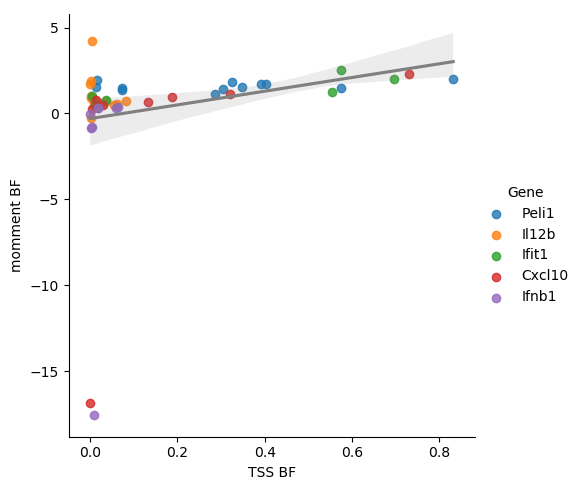

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = 1.727, df = 48, p-value = 0.09059
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03910514  0.48740810
sample estimates:
      cor 
0.2418754 



In [223]:
Seaborn.lmplot(data = Pandas.DataFrame(bfs), x= "TSS BF", y = "momment BF", hue = "Gene",fit_reg = 0)
Seaborn.regplot(data = Pandas.DataFrame(bfs), x= "TSS BF", y = "momment BF", scatter = false, color = "gray")

x = [ii for ii in bfs[!,"TSS BF"]]
y = [ii for ii in bfs[!,"momment BF"]]
R"""cor.test($x, $y)"""

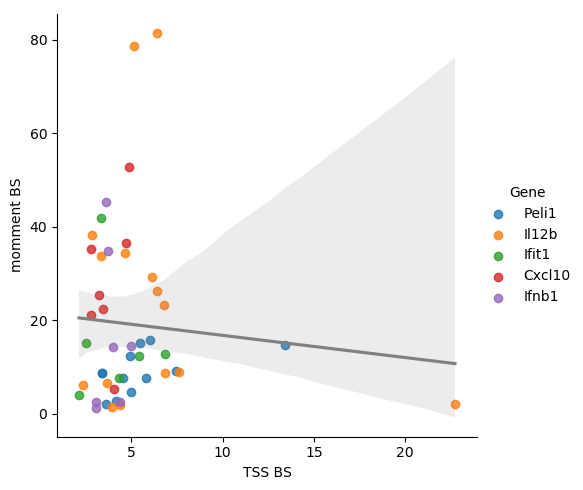

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = -0.55652, df = 45, p-value = 0.5806
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3612667  0.2094628
sample estimates:
        cor 
-0.08267711 



In [224]:
Seaborn.lmplot(data = Pandas.DataFrame(bfs), x= "TSS BS", y = "momment BS", hue = "Gene",fit_reg = 0)
Seaborn.regplot(data = Pandas.DataFrame(bfs), x= "TSS BS", y = "momment BS", scatter = false, color = "gray")
x = [ii for ii in bfs[!,"TSS BS"]]
y = [ii for ii in bfs[!,"momment BS"]]
R"""cor.test($x, $y)"""

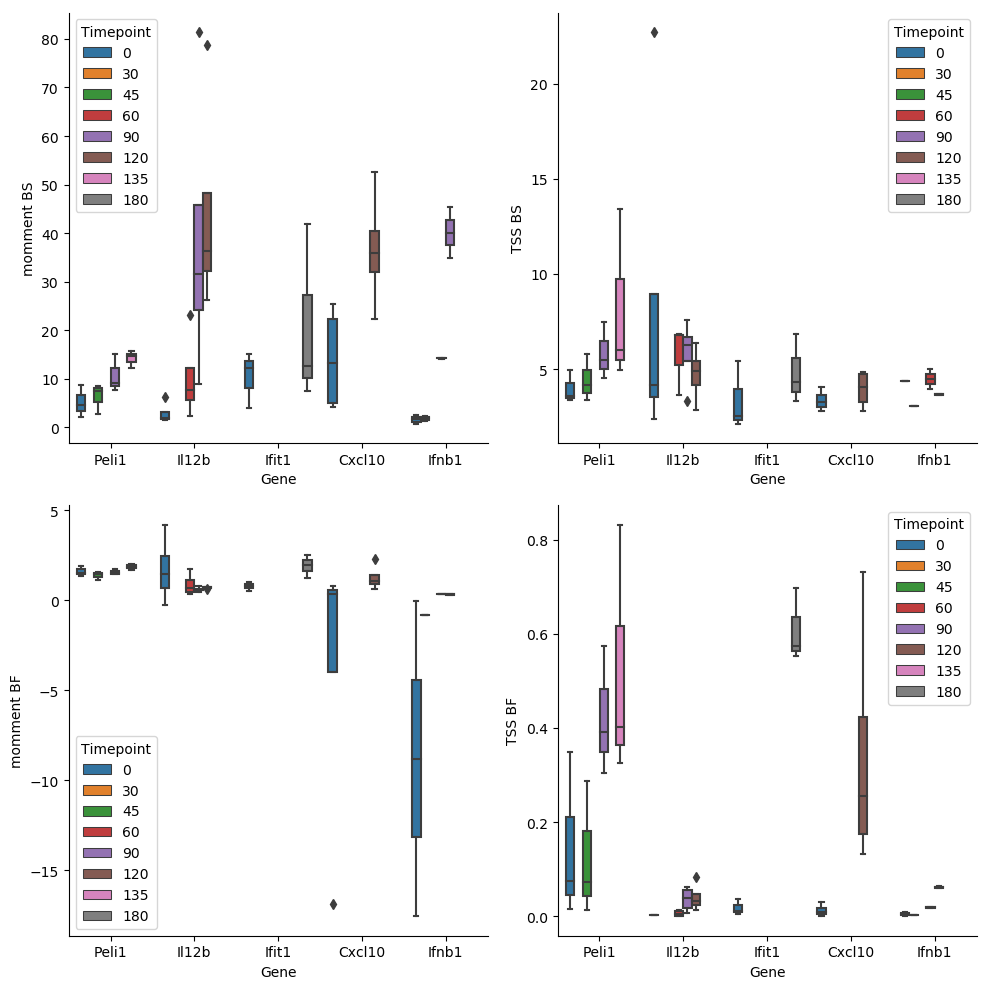

In [229]:
figure(figsize = (10, 10))

subplot(2,2,1)
Seaborn.boxplot(data = Pandas.DataFrame(bfs), x= "Gene", y = "momment BS", hue = "Timepoint");pretty_axes2()
subplot(2,2,2)
Seaborn.boxplot(data = Pandas.DataFrame(bfs), x= "Gene", y = "TSS BS", hue = "Timepoint");pretty_axes2()
subplot(2,2,3)
Seaborn.boxplot(data = Pandas.DataFrame(bfs), x= "Gene", y = "momment BF", hue = "Timepoint");pretty_axes2()
subplot(2,2,4)
Seaborn.boxplot(data = Pandas.DataFrame(bfs), x= "Gene", y = "TSS BF", hue = "Timepoint");pretty_axes2()
plt.tight_layout()

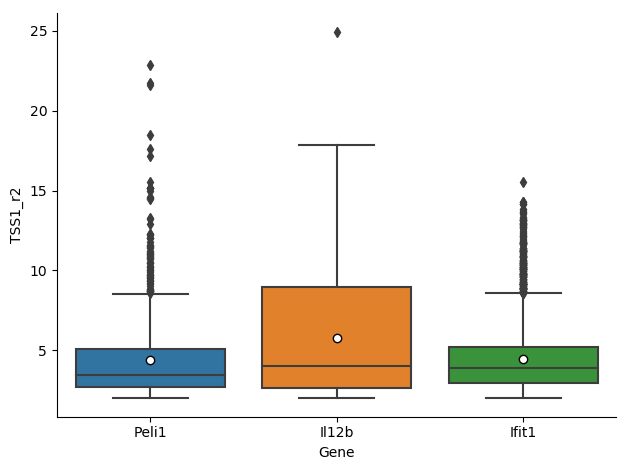

In [226]:
il12b_sub = tss_data(il12b[il12b[!,:Timepoint].==90, :], limit = 2); 
il12b_sub[!,:Gene] = ["Il12b" for ii in 1:nrow(il12b_sub)]

peli1_sub = tss_data(peli1[peli1[!,:Timepoint].==45, :], limit = 2); 
peli1_sub[!,:Gene] = ["Peli1" for ii in 1:nrow(peli1_sub)]
ifit1_sub = tss_data(ifit1[ifit1[!,:Timepoint].==180, :], limit = 2); 
ifit1_sub[!,:Gene] = ["Ifit1" for ii in 1:nrow(ifit1_sub)]


df = join_in_all_common_columns(peli1_sub, il12b_sub, ifit1_sub)


Seaborn.boxplot(data = Pandas.DataFrame(df), x= "Gene", y = "TSS1_r2", showmeans = true, 
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

In [227]:
names(df)

11-element Vector{String}:
 "Image"
 "Cell"
 "Genotype"
 "Timepoint"
 "Rep"
 "TSS1_r2"
 "TSS2_r2"
 "N_exon"
 "Sample"
 "Sample_Rep"
 "Gene"